# C964 Predictive Model Training & Evaluation

## Setup

In [17]:
import logging

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    HistGradientBoostingRegressor,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import KFold, cross_val_predict, cross_validate
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    StandardScaler,
)

%matplotlib inline

logging.getLogger("root").setLevel(logging.ERROR)

In [18]:
# Features file manually encodes the variable type for each selected column for use in training
meta = pd.read_csv("../data/features.csv")
meta

,variable,kind
0,HDD65,numerical
1,CDD65,numerical
2,TYPEHUQ,categorical
3,CELLAR,boolean
4,BASEFIN,boolean
...,...,...
89,EVCHRGHOME,boolean
90,NHSLDMEM,numerical
91,SQFTEST,numerical
92,DBT1,numerical


In [19]:
# Categorize variable by type
numerical_vars = meta.query("`kind` == 'numerical'")["variable"].tolist()
boolean_vars = meta.query("`kind` == 'boolean'")["variable"].tolist()
ordinal_vars = meta.query("`kind` == 'ordinal'")["variable"].tolist()
categorical_vars = meta.query("`kind` == 'categorical'")["variable"].tolist()

# Define target and feature variables
target_vars = ["BTUEL", "BTUNG", "BTULP", "BTUFO", "BTUWD"]
feature_vars = [col for col in list(meta["variable"]) if col not in target_vars]

# Assign features by type
numerical_features = [col for col in numerical_vars if col in feature_vars]
boolean_features = [col for col in boolean_vars if col in feature_vars]
ordinal_features = [col for col in ordinal_vars if col in feature_vars]
categorical_features = [col for col in categorical_vars if col in feature_vars]

# Display counts of features by type
print("numerical_features", len(numerical_features))
print("boolean_features", len(boolean_features))
print("ordinal_features", len(ordinal_features))
print("categorical_features", len(categorical_features))
print("targets", len(target_vars))

numerical_features 36
boolean_features 22
ordinal_features 6
categorical_features 30
targets 5


In [20]:
# Define Pandas datatypes for variables
dtype = {}
for col in categorical_vars + ordinal_vars:
    dtype[col] = "category"
for col in boolean_vars:
    dtype[col] = "boolean"
for col in numerical_vars:
    dtype[col] = "float64"

# Import survey response dataset
data = pd.read_csv(
    "../data/recs2020_public_v5.csv",
    usecols=lambda c: c in (feature_vars + target_vars),
    dtype=dtype,
    na_values=["-2"],
)

targets = data[target_vars]
data = data[feature_vars]

data.head()

,HDD65,CDD65,TYPEHUQ,CELLAR,BASEFIN,ATTIC,ATTICFIN,STORIES,SIZEOFGARAGE,YEARMADERANGE,...,H2OAPT,WHEATSIZ,FUELH2O,MORETHAN1H2O,FUELH2O2,EVCHRGHOME,NHSLDMEM,SQFTEST,DBT1,DBT99
0,3844.0,1679.0,2,False,<NA>,False,<NA>,1,2,4,...,<NA>,3,1,False,NaN,<NA>,2.0,2100.0,92.9,21.6
1,3766.0,1458.0,5,<NA>,<NA>,<NA>,<NA>,NaN,NaN,5,...,False,2,1,False,NaN,<NA>,1.0,590.0,91.3,16.1
2,3819.0,1696.0,5,<NA>,<NA>,<NA>,<NA>,NaN,NaN,3,...,True,4,1,False,NaN,<NA>,1.0,900.0,92.9,21.6
3,2614.0,1718.0,2,False,<NA>,False,<NA>,2,2,5,...,<NA>,3,1,False,NaN,<NA>,2.0,2100.0,91.8,25.1
4,4219.0,1363.0,5,<NA>,<NA>,<NA>,<NA>,NaN,NaN,3,...,True,2,1,False,NaN,<NA>,2.0,800.0,81.8,13.0


## Create Data Pipeline

In [21]:
def create_constant_imputer(fill_value):
    return SimpleImputer(
        strategy="constant", fill_value=fill_value, add_indicator=False
    )


def create_ordinal_transformer(*, fill_value="0", categories="auto"):
    return make_pipeline(
        create_constant_imputer(fill_value), OrdinalEncoder(categories=categories)
    )


default_ordinal_transformer = create_ordinal_transformer()

preprocess_ordinal = ColumnTransformer(
    [
        (
            "SIZEOFGARAGE",
            create_ordinal_transformer(categories=[["0", "1", "2", "3"]]),
            ["SIZEOFGARAGE"],
        ),
        (
            "YEARMADERANGE",
            create_ordinal_transformer(
                categories=[["1", "2", "3", "4", "5", "6", "7", "8", "9"]]
            ),
            ["YEARMADERANGE"],
        ),
        (
            "TYPEGLASS",
            create_ordinal_transformer(categories=[["1", "2", "3"]]),
            ["TYPEGLASS"],
        ),
        (
            "ADQINSUL",
            create_ordinal_transformer(categories=[["1", "2", "3", "4"]]),
            ["ADQINSUL"],
        ),
        (
            "WASHTEMP",
            create_ordinal_transformer(categories=[["0", "1", "2", "3", "0"]]),
            ["WASHTEMP"],
        ),
        (
            "WHEATSIZ",
            create_ordinal_transformer(categories=[["1", "2", "3", "4"]]),
            ["WHEATSIZ"],
        ),
    ],
    remainder=default_ordinal_transformer,
)


preprocess_categorical = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)


preprocess_boolean = make_pipeline(
    create_constant_imputer(fill_value=False),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
)


normalized_transformer = make_pipeline(
    PowerTransformer(method="yeo-johnson", standardize=True)
)

standardized_transformer = make_pipeline(
    create_constant_imputer(fill_value=0), StandardScaler()
)

preprocess_numerical = ColumnTransformer(
    [("normalize", normalized_transformer, ["HDD65", "CDD65", "SQFTEST"])],
    remainder=standardized_transformer,
)

preprocessor = ColumnTransformer(
    [
        ("numerical", preprocess_numerical, numerical_features),
        ("boolean", preprocess_boolean, boolean_features),
        ("ordinal", preprocess_ordinal, ordinal_features),
        ("categorical", preprocess_categorical, categorical_features),
    ],
    remainder="passthrough"
)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical',
                                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                              SimpleImputer(fill_value=0,
                                                                                            strategy='constant')),
                                                                             ('standardscaler',
                                                                              StandardScaler())]),
                                                   transformers=[('normalize',
                                                                  Pipeline(steps=[('powertransformer',
                                                                                   PowerTransformer())]),
                                                                  ['HDD65',
                                                                   'CDD65',
                                                                   'SQFTEST'])]),
                                 ['HDD65', 'CDD65',...
                                 ['TYPEHUQ', 'STORIES', 'WALLTYPE', 'ROOFTYPE',
                                  'FUELPOOL', 'FUELTUB', 'TYPERFR1', 'TYPERFR2',
                                  'LOCRFRI2', 'UPRTFRZR', 'RANGEFUEL',
                                  'COOKTOPFUEL', 'OVENFUEL', 'OUTGRILLFUEL',
                                  'DWCYCLE', 'TOPFRONT', 'DRYRFUEL', 'EQUIPM',
                                  'FUELHEAT', 'EQUIPAUXTYPE', 'FUELAUX',
                                  'HUMIDTYPE', 'ACEQUIPM_PUB',
                                  'ACEQUIPAUXTYPE_PUB', 'DEHUMTYPE',
                                  'TYPETHERM', 'HEATCNTL', 'COOLCNTL',
                                  'FUELH2O', 'FUELH2O2'])])

## Train and Evaluate Regression Models

Coefficient of determination (R²):
0.603 ± 0.027
Mean Absolute Error (MAE):
6902.570 ± 103.021


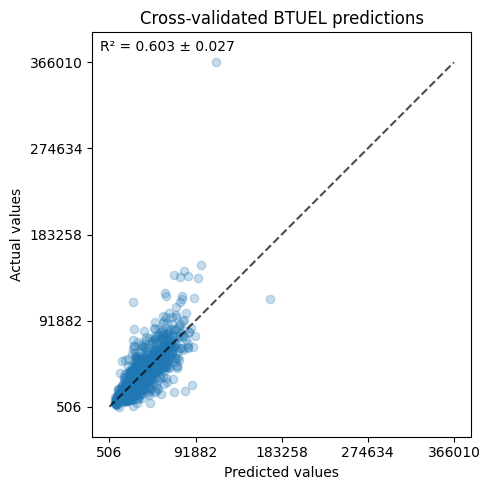

In [22]:
def evaluate_regressor(target_var, regressor):
    target = targets[target_var]
    pipeline = make_pipeline(preprocessor, regressor)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_validate(
        pipeline,
        data,
        target,
        cv=cv,
        scoring=["r2", "neg_median_absolute_error"],
    )
    
    scores = pd.DataFrame(
        {"R2": cv_results["test_r2"], "MAE": -cv_results["test_neg_median_absolute_error"]}
    )
    print(
        "Coefficient of determination (R²):\n"
        f"{scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}"
    )
    print(
        "Mean Absolute Error (MAE):\n"
        f"{scores['MAE'].mean():.3f} ± {scores['MAE'].std():.3f}"
    )
    
    y_pred = cross_val_predict(
        pipeline,
        data,
        target,
        cv=cv,
    )
    
    _, ax = plt.subplots(figsize=(5, 5))
    display = PredictionErrorDisplay.from_predictions(
        target,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.25},
        random_state=42,
    )
    ax.set_title(f"Cross-validated {target_var} predictions")
    ax.text(
        0.02,
        0.98,
        f"R² = {scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}",
        ha="left",
        va="top",
        transform=ax.transAxes,
    )
    plt.tight_layout()
    plt.show()

target_var = "BTUEL"
regressor = lgb.LGBMRegressor(objective="gamma", verbose=-1, random_state=42)

evaluate_regressor(target_var, regressor)

Coefficient of determination (R²):
0.782 ± 0.025
Mean Absolute Error (MAE):
2482.014 ± 330.556


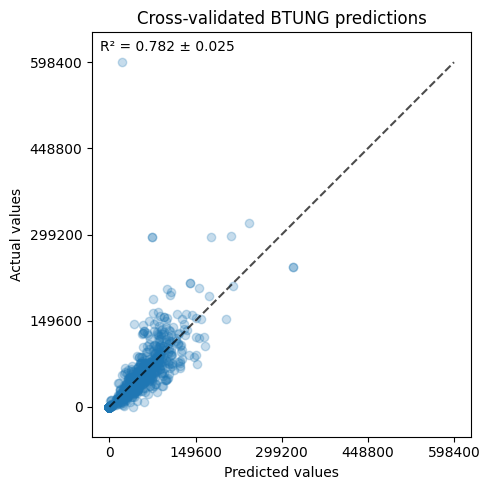

In [23]:
target_var = "BTUNG"
regressor = lgb.LGBMRegressor(objective="tweedie", verbose=-1, random_state=42)

evaluate_regressor(target_var, regressor)

Coefficient of determination (R²):
0.794 ± 0.027
Mean Absolute Error (MAE):
0.020 ± 0.003


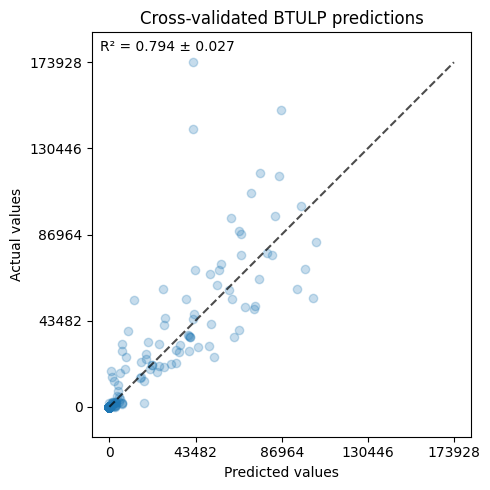

In [24]:
target_var = "BTULP"
regressor = lgb.LGBMRegressor(objective="tweedie", verbose=-1, random_state=42)

evaluate_regressor(target_var, regressor)

In [25]:
target_var = "BTUFO"
regressor = lgb.LGBMRegressor(objective="tweedie", verbose=-1, random_state=42)

evaluate_regressor(target_var, regressor)

Coefficient of determination (R²):
0.626 ± 0.018
Mean Absolute Error (MAE):
0.010 ± 0.003


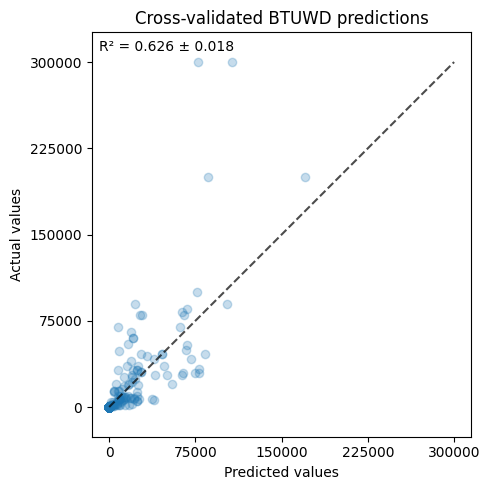

In [ ]:
target_var = "BTUWD"
regressor = lgb.LGBMRegressor(objective="tweedie", verbose=-1, random_state=42)

evaluate_regressor(target_var, regressor)

## Create and Export Final Model

In [ ]:
target = targets

regressor = MultiOutputRegressor(
    HistGradientBoostingRegressor(loss='poisson', random_state=42)
)

model = make_pipeline(preprocessor, regressor)
model.fit(data, target)

filename = "../model.joblib"
joblib.dump(model, filename)

['../model.joblib']